![DSME-logo](../img/DSME_logo.png)

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---

# Dyna-Q vs Q-Learning
*(Adapted from Sutton & Barto, Chapter 8)*

Generating experience can be a resource-intensive task. Consider a physical system where each run generates a monetary cost. In such a case, money can be a limiting factor and the experience generated must be used efficiently. To improve resource efficiency, we have to consider what we use our experience for.
Fundamentally, there are two possible use-cases for the experience we generate: We can learn a value function, or we can use it to improve a model. 
In standard Q-Learning we only improve the value function. However, we can also use the same experience to improve a model in parallel, which we can in turn use for further improvements of the value function. This is the approach Dyna-Q follows. The algorithm is presented below and compared with Q-Learning, to show the improvements in sampling-efficiency.

## Imports

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import custom_envs
import copy
from IPython.display import Video
from IPython.display import display
from matplotlib.animation import FuncAnimation
from utils.visuals import *

## Design of the Agent
The algorithm for Dyna-Q equals the Q-Learning algorithm, however, there is an addition. Each step is used to improve a deterministic model of the environment, from which random samples are generated to improve the value function. The algorithm is presented below:

<img src="./img/dyna-q.png" alt="Environment" width="500" />

The agent is similar to the already presented Q-Learning agent , with two additions:
* `self.model` is a model of the environment, containing the subsequent state and reward for each state-action pair
+ `self.visited_states_and_actions` keeps track of the visited state-action pairs

In [2]:
class TD_Agent():
    def __init__(self, env, gamma=1.0, learning_rate=0.05, epsilon=0.1, dyn_q_iters=25):
        self.env = env
        self.action_value_fn = np.zeros((self.env.observation_space.n, self.env.action_space.n)) # the q-fn
        self.model = np.zeros((self.env.observation_space.n, self.env.action_space.n, 2))
        class StateActionTracker:
            def __init__(self):
                self.states = {}
                self.actions = {}
            def add_state_action_pair(self, state, action):
                if state not in self.states:
                    self.states[state] = 1
                    self.actions[state] = set([action])
                else:
                    self.states[state] += 1
                    if action not in self.actions[state]:
                        self.actions[state].add(action)
            def get_state(self):
                if self.states:
                    return np.random.choice(list(self.states.keys()))
            def get_action(self, state):
                if state in self.actions and self.actions[state]:
                    return np.random.choice(list(self.actions[state]))
        self.visited_states_and_actions = StateActionTracker()
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.dyn_q_iters = dyn_q_iters

    def get_random_action(self):
        random_action = np.random.choice(range(self.env.action_space.n))
        return random_action
    def get_best_action(self, obs):
        best_action = np.random.choice(np.flatnonzero(np.isclose(self.action_value_fn[obs], self.action_value_fn[obs].max(), rtol=0.01)))
        return best_action
    
    def epsilon_greedy_policy(self, obs):
        # returns action, choosing a random action with probability epsilon or the best action based on Q(s,a)
        randomly = np.random.random() < self.epsilon
        if randomly:
            action = self.get_random_action()
        else:
            action = self.get_best_action(obs)
        return action
    
    def q_learning_update(self, obs, action, next_obs, reward):
        best_next_action = self.get_best_action(next_obs)
        td_target = reward + self.gamma * self.action_value_fn[next_obs][best_next_action]
        update = (1-self.learning_rate) * self.action_value_fn[obs][action] + self.learning_rate * td_target
        self.action_value_fn[obs][action] = update
        
    def q_learning(self, num_episodes):
        returns = []
        for i in range(num_episodes):
            returns_i = 0
            obs, info = self.env.reset()
            done = False
            while not done:
                # Generate next_obs and reward based on state-action pair
                action = self.epsilon_greedy_policy(obs)
                next_obs, reward, done, truncated, info = self.env.step(action)
                # Update the value function
                self.q_learning_update(obs, action, next_obs, reward)
                obs = next_obs
                returns_i += reward
            returns.append(returns_i)
        return returns
    
    def dyna_q(self, num_episodes):
        returns = []
        for i in range(num_episodes):
            returns_i = 0
            obs, info = self.env.reset()
            done = False
            while not done:
                # Generate next_obs and reward based on state-action pair
                action = self.epsilon_greedy_policy(obs)
                next_obs, reward, done, truncated, info = env.step(action)
                # Update the value function
                self.q_learning_update(obs, action, next_obs, reward)
                # Update the model
                self.model[obs][action] = np.array([next_obs, reward]) # Assuming deterministic environment
                self.visited_states_and_actions.add_state_action_pair(obs, action)
                returns_i += reward
                obs = next_obs
                # Perform more updates using the model
                for j in range(self.dyn_q_iters):
                    mod_state = self.visited_states_and_actions.get_state()
                    mod_action = self.visited_states_and_actions.get_action(mod_state)
                    mod_next_state, mod_reward = int(self.model[mod_state][mod_action][0]), self.model[mod_state][mod_action][1]
                    self.q_learning_update(mod_state, mod_action, mod_next_state, mod_reward)
            returns.append(returns_i)
        return returns

    def reset(self):
        self.action_value_fn = np.zeros((self.env.observation_space.n, self.env.action_space.n))

## Evaluation of the Training
To compare the two methods, both agents are trained with the same properties. Epsilon is set to 0.2, allowing for occasional random behavior of the agent. We show the return of both agents over the episodes. To allow for improved visualization, the returns are smoothed using the following function:

In [3]:
def smooth(array, size):
    window_size = size
    filter = np.ones(window_size) / window_size
    smoothed_array = np.convolve(array, filter, mode='same')
    return smoothed_array

We train the agents and prove that the learned value functions lead to comparable policies. Additionally we evaluate the policy within the environment:

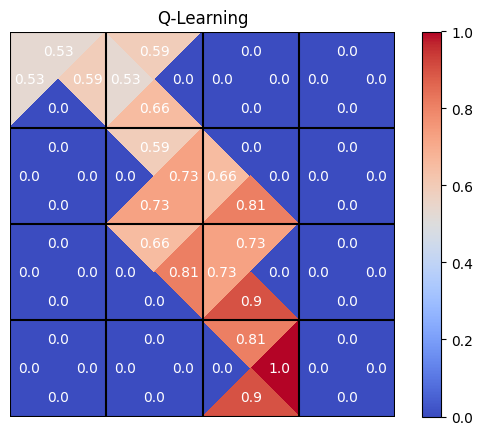

In [4]:
# Import visualization
setattr(TD_Agent, "evaluate", evaluate)

# Set values
map = ["SFHH", "HFFH", "HFFH", "HHFG"]
env = gym.make('CustomFrozenLake-v1', render_mode=None, desc=map, is_slippery=False)
render_env = gym.make('CustomFrozenLake-v1', render_mode='rgb_array', desc=map, is_slippery=False)
filter = 50
num_episodes = 10000
env.reset()

agent_1 = TD_Agent(env, gamma=0.9, learning_rate=0.1, epsilon=0.2)
q_learning_training_history = smooth(agent_1.q_learning(num_episodes=num_episodes), filter)
plot_action_value(agent_1.action_value_fn, "Q-Learning")
video_file_1 = "q_agent.mp4"
agent_1.evaluate(render_env, 1, video_file_1)
Video(video_file_1, html_attributes="loop autoplay")

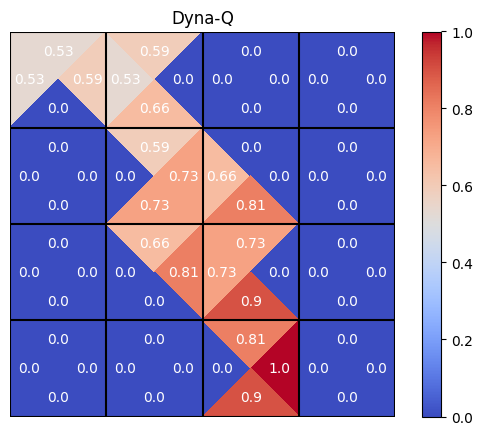

In [5]:
agent_2 = TD_Agent(env, gamma=0.9, learning_rate=0.1, epsilon=0.2)
dyna_q_training_history = smooth(agent_2.dyna_q(num_episodes=num_episodes), filter)
plot_action_value(agent_2.action_value_fn, "Dyna-Q")
video_file_2 = "dyna_q_agent.mp4"
agent_2.evaluate(render_env, 1, video_file_2)
Video(video_file_2, html_attributes="loop autoplay")

Lastly, we show how much more efficient the learning with Dyna-Q is, compared to Q-learning:

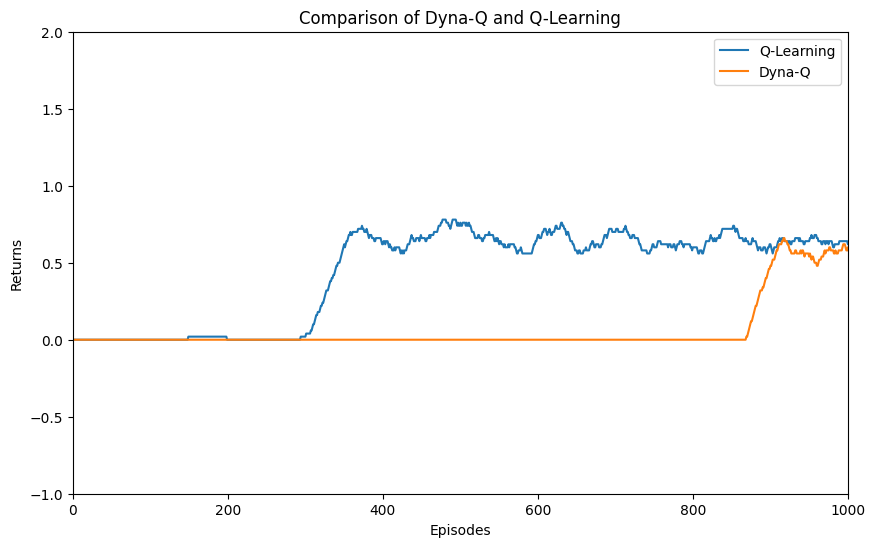

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and an axes.
ax.plot(range(num_episodes), q_learning_training_history, label="Q-Learning")
ax.plot(range(num_episodes), dyna_q_training_history, label="Dyna-Q")
ax.grid(False)
ax.set_xlabel('Episodes')
ax.set_ylabel('Returns')
ax.set_title("Comparison of Dyna-Q and Q-Learning")
ax.set_ylim(-1, 2)
ax.set_xlim(0, 1000)
ax.legend()
plt.show()